# Introduction
## Question
How have the lyrics of the most popular songs in the US changed over time?
## Why Does It Matter?
From lullabies to birthday to dirges, music color and reflect our experiences. Music provides insight in the culture, norms, rituals, and values of a society. I am interested in observing the zeitgeist of the US through the years and how it changes. In relation to the data, I am interested in what popular music--specifically the number one single in Billboard's charts--can say about the people in the era and society.

Although the most popular song is decided by a wide variety of factors, one of the factors is the appeal to the general public, which is why I can gain insight to the time period through its  popular songs. It may bold assumption to make, but I think the lyrics of the songs every decade would be able to at least reflect, if not the zeitgeist,  some aspect of the culture at that decade.
# Sources
I am defining most popular song in the US as the #1 Billboard single in that decade. I’m getting the information of the #1 Billboard single from Wikipedia articles with links of the form “https://en.wikipedia.org/wiki/Billboard_year-end_top_30_singles_of_(year)”.

I’m using the Wikipedia articles as my source of information because I know Wikipedia allows web scraping. I've compared it with several other websites and the information matches up, so I think this is a trustworthy source.

I’m getting the lyrics by Googling the name of the songs and finding the first relevant results that don’t including [CHORUS] [VERSE 1] and the like. It’s much more manual but I haven’t found a less labor-intensive method of finding lyrics, especially for some of the older songs.

# Workflow
1. Collect songs from Wikipedia in the Jupyter notebook `Collecting Billboard Top 100 From Wikipedia`.
2. Import it into Google Sheets and manually populate the "Lyrics" column.
    a. Took the top result for "(song_title) lyrics" in a Google search that didn't contain extraneous features ([CHORUS], [VERSE], and the like)
3. Export it as a .csv file and import it into this Jupyter notebook for data exploration.
## CTA Analysis:

1. Preprocessing Lyrics without punctuation, lyrics by phrases, lyrics by words.
2. Basic: Unique artists in decade, unique artists, number of times artists appear, unique phrases, average character count, average word count.
3. Frequency: Parts of speech distribution (by decade), sepculative words, personal pronouns (total, first vs second, first person singular vs first person plural, genders), lexical diversity.
4. Network graph
5. Sentiment analysis (by phrases)
6. Common words: direct count (without stopwords), TF-IDF, topic modeling

# Assumptions & Concerns
I am using an equal number of songs from each decade to combat imbalances.
However, since I need to manually input the lyrics, the number of songs used is very few so I may end up drawing wrong conclusions based on unique characteristics of the specific songs I chose. Because of that, I'm making a huge assumption that my data is representative of the whole decade. However, I'm adding more lyrics to the list and re-running everything so I hope as I add more data, the assumption will become less of a stretch.
The underlying phenomena is the zeitgeist of each decade, and I am using the lyrics of the popular songs as a latent variable to investigate this.

Subsets:
1. 7 data points
    * #1 song in 1950, 1960, 1970, 1980, 1990, 2000, 2010
2. 14 data points
    * #1 song in 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015
3. 28 data points
    * #1 & #2 songs in 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015
4. 68 data points
    * #1 song from each year from 1950 to 2018
4. 136 data points
    * #1 & #2 songs from each year from 1950 to 2018
    
# Tools & Methods
## Preliminary Importing

In [59]:
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from wordcloud import WordCloud

from collections import Counter
from string import punctuation

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("seaborn-pastel")

# Data

In [60]:
#This is the saved csv file from Google Sheets with lyrics added to web-scrapped data
full_music = pd.read_csv("Billboard100(1950-2018).csv")
pd.to_numeric(full_music["Year"])
top30 = full_music.loc[full_music["Position"].isin([str(i) for i in np.arange(1, 30)])].reset_index(drop=True)
#Get the songs from the Billboard entries every 5 years
#subset_music = full_music.loc[full_music["Year"]%5 == 0]
subset_music = full_music
#Only get the #1 and #2 song in each Billboard entry
data = subset_music.loc[subset_music["Position"].isin(["1", "2"])].reset_index(drop=True)
print(data.shape)
data

(138, 5)


,Position,Song,Artist,Year,Lyrics
0,1,"""Goodnight Irene""",Gordon Jenkins & The Weavers,1950,"Irene, goodnight\nIrene, goodnight\nGoodnight,..."
1,2,"""Mona Lisa""",Nat King Cole,1950,"Mona lisa, mona lisa, men have named you\nyou'..."
2,1,"""Too Young""",Nat King Cole,1951,"Too young to go steady\nToo young, I hear her ..."
3,2,"""Because of You""",Tony Bennett,1951,Because of you there's a song in my heart\nBec...
4,1,"""Blue Tango""",Leroy Anderson,1952,Here am I with you in a world of blue\nAnd we'...
5,2,"""Wheel of Fortune""",Kay Starr,1952,The wheel of fortune\nGoes spinning around\nWi...
6,1,"""The Song from Moulin Rouge""",Percy Faith,1953,"When ever we kiss,\nI worry and wonder.\nYour ..."
7,2,"""Vaya con Dios""",Les Paul & Mary Ford,1953,"Now the hacienda's dark, the town is sleeping;..."
8,1,"""Little Things Mean a Lot""",Kitty Kallen,1954,Blow me a kiss from across the room\nSay I loo...
9,2,"""Wanted""",Perry Como,1954,"Wanted, someone who kissed me\nAnd held me clo..."


In [61]:
#Remove punctuation
data["Lyrics w/o Punctuation"] = [lyrics.lower().replace("\n"," ").translate(str.maketrans('', '', punctuation)) 
                                  for lyrics in data["Lyrics"]]
#Phrase tokenize
data["Lyrics by Phrases"] = [set([phrase.translate(str.maketrans('', '', punctuation)) 
                                  for phrase in lyrics.lower().split("\n") if phrase])
                             for lyrics in data["Lyrics"]]
#Word tokenize
data["Lyrics by Words"] = [word_tokenize(lyrics) for lyrics in data["Lyrics w/o Punctuation"]]
#Create a decade column
data["Decade"] = [int(year/10) for year in data["Year"]]
music = data.groupby("Decade").agg(list)
music["Decade"] = [str(year[0])+"s" for year in music["Year"]]
#Create a table with the decade and the lyrics of the top 2 songs in XXX0 and XXX5
music = music.reset_index(drop=True)[["Decade", "Lyrics", "Lyrics w/o Punctuation", 
                                      "Lyrics by Phrases", "Lyrics by Words"]]
music

,Decade,Lyrics,Lyrics w/o Punctuation,Lyrics by Phrases,Lyrics by Words
0,1950s,"[Irene, goodnight\nIrene, goodnight\nGoodnight...",[irene goodnight irene goodnight goodnight ire...,"[{stay there by your fireside bright, stop sta...","[[irene, goodnight, irene, goodnight, goodnigh..."
1,1960s,[There's a summer place\nWhere it may rain or ...,[theres a summer place where it may rain or st...,"[{your arms reach out to me, where it may rain...","[[theres, a, summer, place, where, it, may, ra..."
2,1970s,"[When you're weary, feeling small\nWhen tears ...",[when youre weary feeling small when tears are...,"[{like a bridge over troubled water, when your...","[[when, youre, weary, feeling, small, when, te..."
3,1980s,"[Color me your color, baby\nColor me your car\...",[color me your color baby color me your car co...,"[{color me your color darling, ill never get e...","[[color, me, your, color, baby, color, me, you..."
4,1990s,[I know there's pain\nWhy do you lock yourself...,[i know theres pain why do you lock yourself u...,"[{i know that there is pain, cant you change i...","[[i, know, theres, pain, why, do, you, lock, y..."
5,2000s,[I can feel the magic floating in the air\nBei...,[i can feel the magic floating in the air bein...,"[{the whole world just fades away, because i c...","[[i, can, feel, the, magic, floating, in, the,..."
6,2010s,[Wake up in the morning feeling like P Diddy (...,[wake up in the morning feeling like p diddy h...,[{aint got a care in world but got plenty of b...,"[[wake, up, in, the, morning, feeling, like, p..."


# Text Analysis
## Basic

In [62]:
top30["Decade"] = [int(year/10) for year in top30["Year"]]
artist_count = top30.groupby("Decade").agg(list)
#Count the number of unique artists in each decade (the rest have appeared on the list in the same decade)
artist_count["Unique Artists in Decade"] = [len(set(artists))/len(artists) for artists in artist_count["Artist"]]
all_artists = []
num_unique = []
for decade in artist_count["Artist"]:
    num_unique += [len(set([artist for artist in decade if artist not in all_artists]))/len(decade)]
    all_artists += decade
#Count the number of unique artists in each decade (the rest have appeared on the list in any of the previous decades)
artist_count["Unique Artists"] = num_unique
artist_count

,Position,Song,Artist,Year,Lyrics,Unique Artists in Decade,Unique Artists
Decade,,,,,,,
195,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[""Goodnight Irene"", ""Mona Lisa"", ""Third Man Th...","[Gordon Jenkins & The Weavers, Nat King Cole, ...","[1950, 1950, 1950, 1950, 1950, 1950, 1950, 195...","[Irene, goodnight\nIrene, goodnight\nGoodnight...",0.558621,0.558621
196,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[""Theme from A Summer Place"", ""He'll Have to G...","[Percy Faith, Jim Reeves, The Everly Brothers,...","[1960, 1960, 1960, 1960, 1960, 1960, 1960, 196...",[There's a summer place\nWhere it may rain or ...,0.768966,0.703448
197,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[""Bridge Over Troubled Water"", ""(They Long to ...","[Simon & Garfunkel, The Carpenters, The Guess ...","[1970, 1970, 1970, 1970, 1970, 1970, 1970, 197...","[When you're weary, feeling small\nWhen tears ...",0.741379,0.665517
198,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[""Call Me"", ""Another Brick in the Wall, Part I...","[Blondie, Pink Floyd, Olivia Newton-John, Mich...","[1980, 1980, 1980, 1980, 1980, 1980, 1980, 198...","[Color me your color, baby\nColor me your car\...",0.710345,0.627586
199,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[""Hold On"", ""It Must Have Been Love"", ""Nothing...","[Wilson Phillips, Roxette, Sinéad O'Connor, Be...","[1990, 1990, 1990, 1990, 1990, 1990, 1990, 199...",[I know there's pain\nWhy do you lock yourself...,0.693103,0.617241
200,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[""Breathe"", ""Smooth"", ""Maria Maria"", ""I Wanna ...","[Faith Hill, Santana featuring Rob Thomas, San...","[2000, 2000, 2000, 2000, 2000, 2000, 2000, 200...",[I can feel the magic floating in the air\nBei...,0.741379,0.672414
201,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[""Tik Tok"", ""Need You Now"", ""Hey, Soul Sister""...","[Kesha, Lady Antebellum, Train, Katy Perry fea...","[2010, 2010, 2010, 2010, 2010, 2010, 2010, 201...",[Wake up in the morning feeling like P Diddy (...,0.727969,0.666667


In [63]:
#Count all the times the artists appear.
all_artists_count = Counter(all_artists)
all_artists_df = pd.DataFrame(data={"Name":list(all_artists_count.keys()),
                                    "Count":list(all_artists_count.values())}).sort_values("Count", ascending=False)
all_artists_df.head()

,Name,Count
96,Elvis Presley,16
744,Mariah Carey,15
1026,Rihanna,11
19,Perry Como,11
652,Madonna,10


In [64]:
percent = []
for i in np.arange(len(music["Lyrics by Phrases"])):
    unique_phrases = music["Lyrics by Phrases"][i]
    decade_percent = []
    for j in np.arange(len(unique_phrases)):
        total_phrases = music["Lyrics"][i][j]
        total_phrases = [phrase.translate(str.maketrans('', '', punctuation)) 
                         for phrase in total_phrases.lower().split("\n") if phrase]
        decade_percent += [len(unique_phrases[j])/len(total_phrases)]
    percent += [np.mean(decade_percent)]
music["Unique Phrases"] = percent
music

,Decade,Lyrics,Lyrics w/o Punctuation,Lyrics by Phrases,Lyrics by Words,Unique Phrases
0,1950s,"[Irene, goodnight\nIrene, goodnight\nGoodnight...",[irene goodnight irene goodnight goodnight ire...,"[{stay there by your fireside bright, stop sta...","[[irene, goodnight, irene, goodnight, goodnigh...",0.691877
1,1960s,[There's a summer place\nWhere it may rain or ...,[theres a summer place where it may rain or st...,"[{your arms reach out to me, where it may rain...","[[theres, a, summer, place, where, it, may, ra...",0.716334
2,1970s,"[When you're weary, feeling small\nWhen tears ...",[when youre weary feeling small when tears are...,"[{like a bridge over troubled water, when your...","[[when, youre, weary, feeling, small, when, te...",0.637274
3,1980s,"[Color me your color, baby\nColor me your car\...",[color me your color baby color me your car co...,"[{color me your color darling, ill never get e...","[[color, me, your, color, baby, color, me, you...",0.690124
4,1990s,[I know there's pain\nWhy do you lock yourself...,[i know theres pain why do you lock yourself u...,"[{i know that there is pain, cant you change i...","[[i, know, theres, pain, why, do, you, lock, y...",0.655304
5,2000s,[I can feel the magic floating in the air\nBei...,[i can feel the magic floating in the air bein...,"[{the whole world just fades away, because i c...","[[i, can, feel, the, magic, floating, in, the,...",0.588911
6,2010s,[Wake up in the morning feeling like P Diddy (...,[wake up in the morning feeling like p diddy h...,[{aint got a care in world but got plenty of b...,"[[wake, up, in, the, morning, feeling, like, p...",0.615699


In [65]:
#Get average character count
music["Avg Character Count"] = [np.mean([len(lyrics.replace(" ","")) 
                                         for lyrics in decade])
                                for decade in music["Lyrics w/o Punctuation"]]
#Get average word count
music["Avg Word Count"] = [np.mean([len(lyrics) 
                                    for lyrics in decade]) 
                           for decade in music["Lyrics by Words"]]
music.head()

,Decade,Lyrics,Lyrics w/o Punctuation,Lyrics by Phrases,Lyrics by Words,Unique Phrases,Avg Character Count,Avg Word Count
0,1950s,"[Irene, goodnight\nIrene, goodnight\nGoodnight...",[irene goodnight irene goodnight goodnight ire...,"[{stay there by your fireside bright, stop sta...","[[irene, goodnight, irene, goodnight, goodnigh...",0.691877,681.80,174.40
1,1960s,[There's a summer place\nWhere it may rain or ...,[theres a summer place where it may rain or st...,"[{your arms reach out to me, where it may rain...","[[theres, a, summer, place, where, it, may, ra...",0.716334,704.05,187.10
2,1970s,"[When you're weary, feeling small\nWhen tears ...",[when youre weary feeling small when tears are...,"[{like a bridge over troubled water, when your...","[[when, youre, weary, feeling, small, when, te...",0.637274,951.75,252.45
3,1980s,"[Color me your color, baby\nColor me your car\...",[color me your color baby color me your car co...,"[{color me your color darling, ill never get e...","[[color, me, your, color, baby, color, me, you...",0.690124,1048.25,280.50
4,1990s,[I know there's pain\nWhy do you lock yourself...,[i know theres pain why do you lock yourself u...,"[{i know that there is pain, cant you change i...","[[i, know, theres, pain, why, do, you, lock, y...",0.655304,1449.10,392.35


## Visualization
### Unique Artists

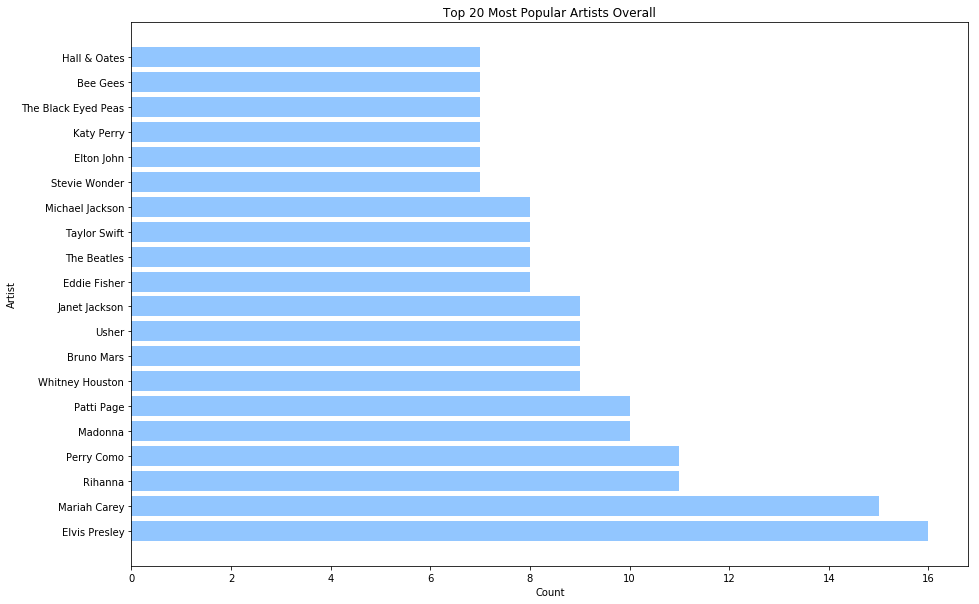

In [66]:
all_artists = Counter(all_artists_df)
plt.figure(figsize=(15,10))
plt.barh(all_artists_df["Name"][:20], all_artists_df["Count"][:20])
plt.xlabel("Count")
plt.ylabel("Artist")
plt.title("Top 20 Most Popular Artists Overall");
#plt.savefig("img/popularbar.tiff");

Range: 16 to 1


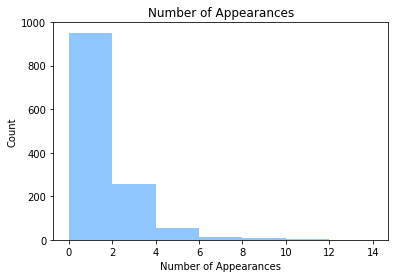

In [67]:
counts = list(all_artists_df["Count"])
print("Range:", str(counts[0]), "to", str(counts[-1]))
plt.hist(all_artists_df["Count"], bins=np.arange(0, 16, 2))
plt.xlabel("Number of Appearances")
plt.ylabel("Count")
plt.title("Number of Appearances");
#plt.savefig("img/numappear.tiff");

### Repetitiveness

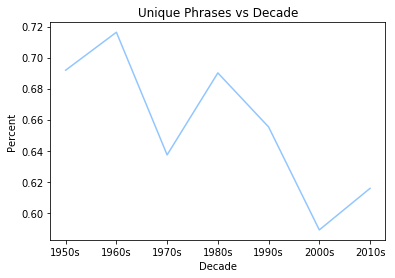

In [68]:
plt.plot(music["Decade"], music["Unique Phrases"])
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.title("Unique Phrases vs Decade");
#plt.savefig("img/repvsdecade.tiff");

### Number of Characters

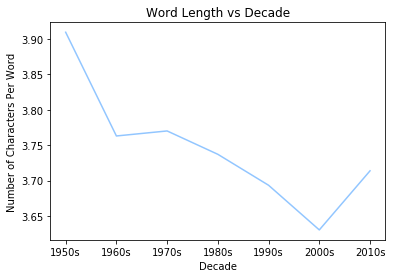

In [69]:
plt.plot(music["Decade"], music["Avg Character Count"]/music["Avg Word Count"])
plt.ylabel("Number of Characters Per Word")
plt.xlabel("Decade")
plt.title("Word Length vs Decade");
#plt.savefig("img/wordlenvsdecade.tiff");

### Number of Words

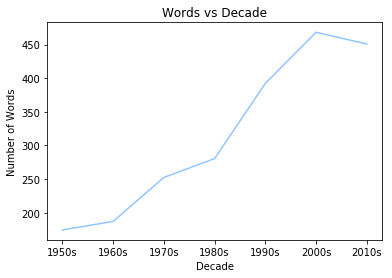

In [70]:
plt.plot(music["Decade"], music["Avg Word Count"])
plt.ylabel("Number of Words")
plt.xlabel("Decade")
plt.title("Words vs Decade");
#plt.savefig("img/wordsvsdecade.tiff");

## Frequency Analysis

In [71]:
decade_pov_single_1 = []
decade_pov_plural_1 = []
decade_pov_2 = []
decade_male = []
decade_female = []
decade_pov_inc = []
decade_pov_ego = []
first_person_single = ["i", "me", "my", "myself", "mine"]
first_person_plural = ["we", "us", "our", "ours"]
second_person = ["you", "your", "yours", "yourself", "yourselves"]
male = ["he", "his", "him"]
female = ["she", "her", "hers"]
for decade in music["Lyrics by Words"]:
    
    songs_pov_single_1 = []
    songs_pov_plural_1 = []
    songs_pov_2 = []
    songs_male = []
    songs_female = []
    
    for song in decade:
        
        words_first_single = 0
        words_first_plural = 0
        words_second = 0
        words_male = 0
        words_female = 0
        
        for word in song:
            
            #Count number of words in first person singular
            if word in first_person_single:
                words_first_single += 1
                
            #Count number of words in first person plural
            if word in first_person_plural:
                words_first_plural += 1
                
            #Count number of words in second person
            if word in second_person:
                words_second += 1
                
            #Count number of male pronouns
            if word in male:
                words_male += 1
                
            #Count number of female pronouns
            if word in female:
                words_female += 1
                
        #Put it in terms of the whole song
        song_len = len(song)
        songs_pov_single_1 += [words_first_single/song_len]
        songs_pov_plural_1 += [words_first_plural/song_len]
        songs_pov_2 += [words_second/song_len]
        songs_male += [words_male/song_len]
        songs_female += [words_female/song_len]
        
    songs_pov_single_1 = np.mean(songs_pov_single_1)
    songs_pov_plural_1 = np.mean(songs_pov_plural_1)
    songs_pov_2 = np.mean(songs_pov_2)
    songs_male = np.mean(songs_male)
    songs_female = np.mean(songs_female)
    
    #Find the mean in each decade
    decade_pov_single_1 += [songs_pov_single_1]
    decade_pov_plural_1 += [songs_pov_plural_1]
    decade_pov_2 += [songs_pov_2]
    decade_male += [songs_male]
    decade_female += [songs_female]
    decade_pov_inc += [songs_pov_plural_1 + songs_pov_2]
    decade_pov_ego += [songs_pov_single_1 + songs_pov_plural_1]

In [72]:
def pos_counter(pos_tag):
    
    pos = []
    freq = []
    
    for _, tag in pos_tag:
        
        if tag not in pos:
            pos += [tag]
            freq += [1]
        else:
            freq[pos.index(tag)] += 1
            
    freq = freq/np.sum(freq)
    return pos, freq

In [73]:
decade_pos_tag = []
decade_pos = {}

for i in np.arange(len(music["Lyrics by Words"])):
    
    decade = music["Lyrics by Words"][i]
    decade_pos_tag += [[]]
    decade_dict = {}
    
    #Populate the dictionary of the decade with the POS frequencies for each song
    for j in np.arange(len(decade)):
        
        song = decade[j]
        decade_pos_tag[i] += [pos_tag(song)]
        pos = pos_counter(decade_pos_tag[i][j])
        label = pos[0]
        freq = pos[1]
        
        for label, freq in zip(label, freq):
            
            if label in decade_pos:
                decade_dict[label] += [freq]
            else:
                decade_dict[label] = [freq]
                
    #Combine each song's frequencies into a mean
    for item in decade_dict:
        decade_dict[item] = np.mean(decade_dict[item])
        
    #Add it to the decade_pos dictionary
    decade_pos[music["Decade"][i]] = decade_dict

In [74]:
#WDT: wh-determiner, which
#WP: wh-pronoun, who, what
#WP$: possessive wh-pronoun, whose
#WRB: wh-abverb, where, when
decade_spec = []

#PRP: personal pronoun, I, he, she
decade_prp = []

#PRP$: possessive pronoun, my, his, hers
decade_prps = []

#PRP + PRP$
decade_prgen = []

for decade in decade_pos:
    
    pos = decade_pos[decade]
    
    prp = 0
    if "PRP" in pos:
        prp = pos["PRP"]
    decade_prp += [prp]  
    
    prps = 0
    if "PRP$" in pos:
        prps = pos["PRP$"]
    decade_prps += [prps] 
    
    decade_prgen += [prp + prps]
    
    spec = 0
    if "WDT" in pos:
        spec += pos["WDT"]
    if "WP" in pos:
        spec += pos["WP"]
    if "WP$" in pos:
        spec += pos["WP$"]
    if "WRB" in pos:
        spec += pos["WRB"]
    decade_spec += [spec]

In [75]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None

In [76]:
def lemmatize(word, tag):
    
    tag = get_wordnet_pos(tag)
    
    if tag:
        return lemmatizer.lemmatize(word, tag)
    else:
        return lemmatizer.lemmatize(word)

In [77]:
stop_words = set(stopwords.words('english')) 
lemmatizer = WordNetLemmatizer()

unique_lyrics = []
unique_lyrics_no_stopwords = []

for i in np.arange(len(music)):
    
    decade = decade_pos_tag[i]
    unique_lyrics += [[]]
    unique_lyrics_no_stopwords += [[]]
    
    for j in np.arange(len(decade)):
        
        song = decade[j]
        
        #lemmatize words. I removed punctuations so i'll -> ill != i != ive
        unique_lyrics[i] += [set([lemmatize(word, tag) for (word, tag) in song])]
        
    #remove stopwords from unique_lyrics' entry.
    unique_lyrics_no_stopwords[i] += [[w for w in song if not w in stop_words] for song in unique_lyrics[i]] 

In [78]:
#find the average number of unique words (with and without stopwords)
len_unique = []
len_unique_no_stop = []

for i in np.arange(len(music)):
    
    decade = unique_lyrics[i]
    decade_no_stop = unique_lyrics_no_stopwords[i]
    
    unique = []
    unique_no_stop = []
    for j in np.arange(len(decade)):
        
        unique += [len(decade[j])]
        unique_no_stop += [len(decade_no_stop[j])]
    
    len_unique += [np.mean(unique)]
    len_unique_no_stop += [np.mean(unique_no_stop)]
len_unique_percent = len_unique/music["Avg Word Count"]
len_unique_no_stop_percent = len_unique_no_stop/music["Avg Word Count"]

## Visualization
### Parts of Speech

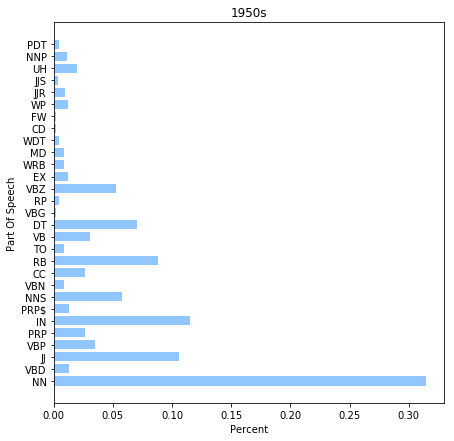

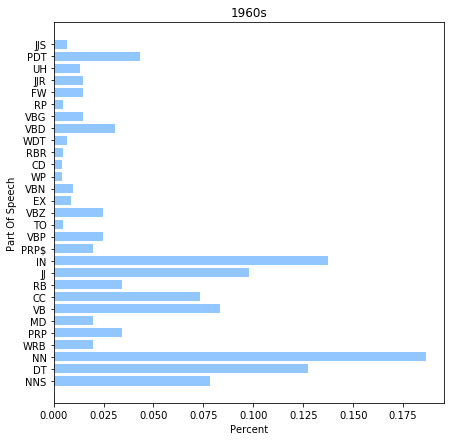

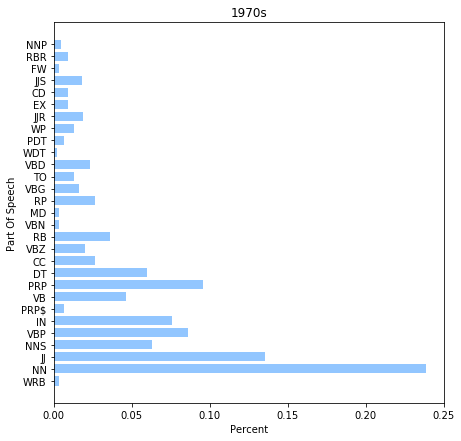

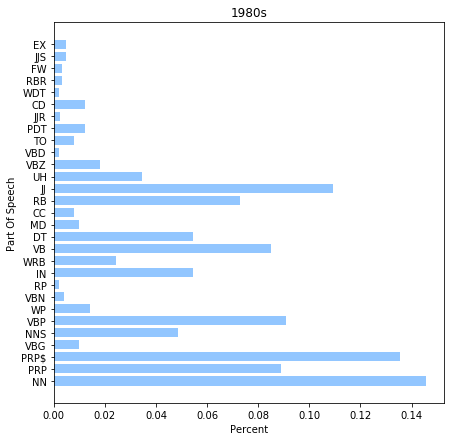

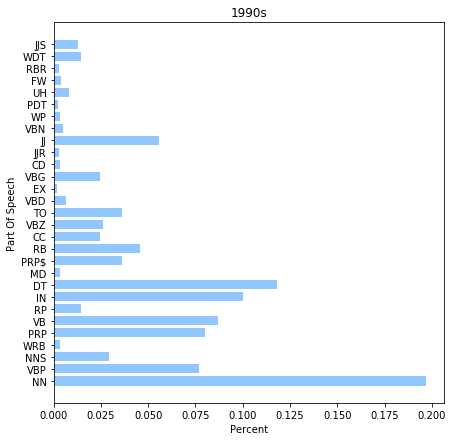

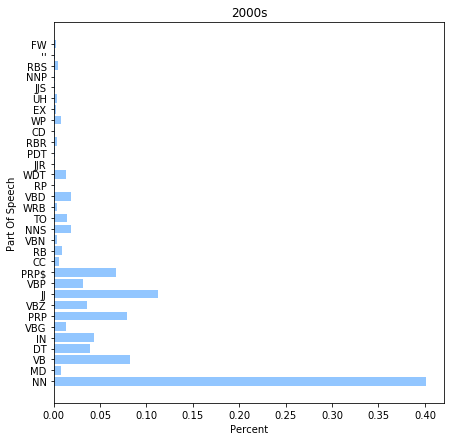

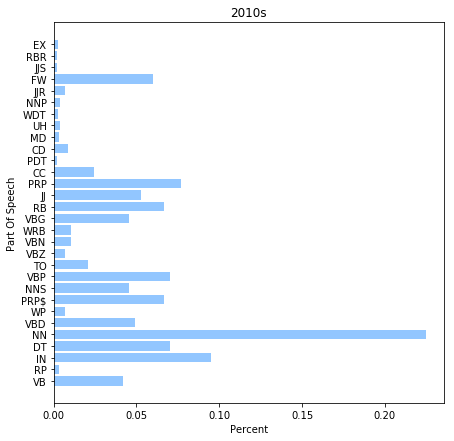

In [79]:
for decade in decade_pos:
    plt.figure(figsize=(7,7))
    plt.title(decade)
    plt.barh(list(decade_pos[decade].keys()), list(decade_pos[decade].values()))
    plt.ylabel("Part Of Speech")
    plt.xlabel("Percent")
    #plt.savefig("img/"+decade+"pos.tiff")
    plt.show();

### Speculative Words

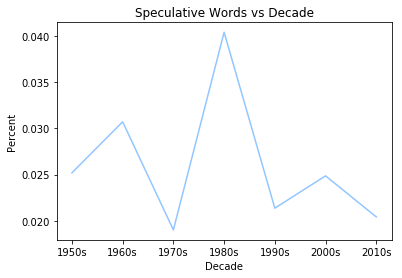

In [80]:
plt.plot(music["Decade"], decade_spec)
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.title("Speculative Words vs Decade");
#plt.savefig("img/specvsdecade.tiff");

### Personal Pronouns

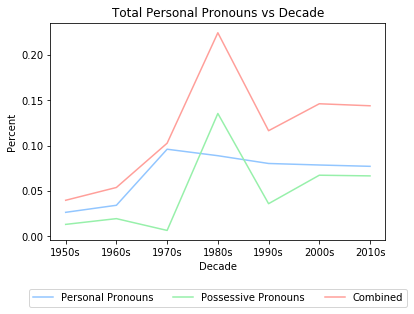

In [81]:
plt.plot(music["Decade"], decade_prp, label="Personal Pronouns")
plt.plot(music["Decade"], decade_prps, label="Possessive Pronouns")
plt.plot(music["Decade"], decade_prgen, label="Combined")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("Total Personal Pronouns vs Decade");
#plt.savefig("img/prpvsdecade.tiff");

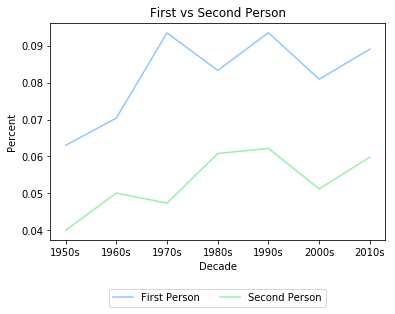

In [82]:
plt.plot(music["Decade"], decade_pov_ego, label="First Person")
plt.plot(music["Decade"], decade_pov_2, label="Second Person")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("First vs Second Person");
#plt.savefig("img/firstvssecond.tiff");

### Intimacy

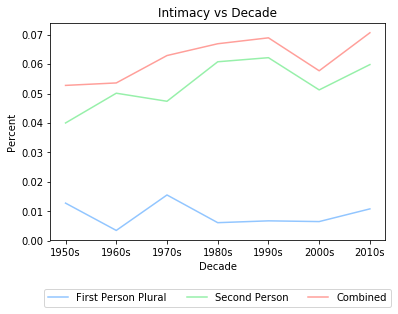

In [83]:
plt.plot(music["Decade"], decade_pov_plural_1, label="First Person Plural")
plt.plot(music["Decade"], decade_pov_2, label="Second Person")
plt.plot(music["Decade"], decade_pov_inc, label="Combined")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("Intimacy vs Decade");
#plt.savefig("img/intimvsdecade.tiff");

### Egocentricity

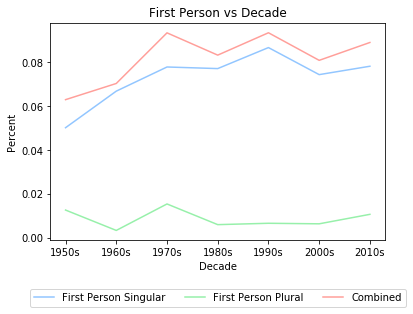

In [84]:
plt.plot(music["Decade"], decade_pov_single_1, label="First Person Singular")
plt.plot(music["Decade"], decade_pov_plural_1, label="First Person Plural")
plt.plot(music["Decade"], decade_pov_ego, label="Combined")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("First Person vs Decade");
#plt.savefig("img/firstvsdecade.tiff");

### Gendered Pronouns

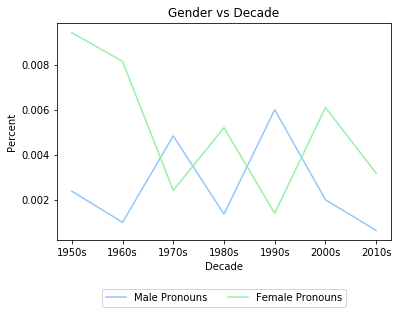

In [85]:
plt.plot(music["Decade"], decade_male, label="Male Pronouns")
plt.plot(music["Decade"], decade_female, label="Female Pronouns")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("Gender vs Decade");
#plt.savefig("img/gendervsdecade.tiff");

### Uniqueness (Lexical Diversity)

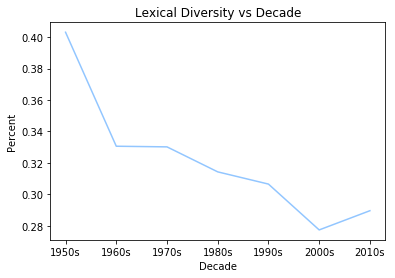

In [86]:
plt.plot(music["Decade"], len_unique_percent)
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.title("Lexical Diversity vs Decade");
#plt.savefig("img/uniquestopvsdecade.tiff");

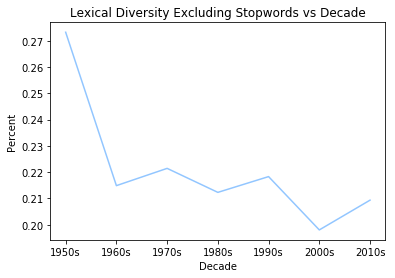

In [87]:
plt.plot(music["Decade"], len_unique_no_stop_percent)
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.title("Lexical Diversity Excluding Stopwords vs Decade");
#plt.savefig("img/uniquenostopcountvsdecade.tiff");

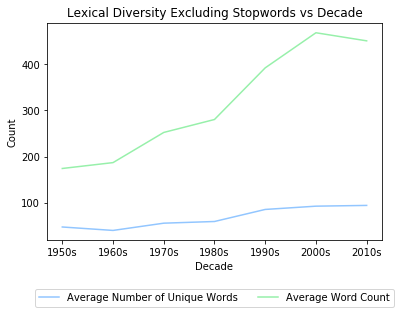

In [88]:
plt.plot(music["Decade"], len_unique_no_stop, label="Average Number of Unique Words")
plt.plot(music["Decade"], music["Avg Word Count"], label="Average Word Count")
plt.ylabel("Count")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("Lexical Diversity Excluding Stopwords vs Decade");
#plt.savefig("img/uniquenostopcountvsdecade.tiff");

## Network Graph

In [89]:
#List of all nodes
all_nodes = []

decades = music["Decade"]
#Removes duplicate years
years = set(data["Year"])
songs = data["Song"]
#Removes quotes around song titles
songs = [song.replace("\"", "") for song in songs]
unique_words_no_stop = unique_lyrics_no_stopwords

all_nodes.extend(decades)
all_nodes.extend(years)
all_nodes.extend(songs)
for decade in unique_words_no_stop:
    for song in decade:
        all_nodes.extend(song)
        
node_type = []
node_type += ["Decade"] * len(decades)
node_type += ["Year"] * len(years)
node_type += ["Song"] * len(songs)
node_type += ["Words"] * (len(all_nodes) - len(node_type))

type_corr = {"Decade":4, "Year":3, "Song":2, "Words":1}
int_type = [type_corr.get(num) for num in node_type]

all_nodes = pd.DataFrame(data={"Id":all_nodes, "Label":all_nodes, "Type":node_type, "Int Type":int_type})
print(all_nodes.shape)
all_nodes.head()

(9547, 4)


,Id,Label,Type,Int Type
0,1950s,1950s,Decade,4
1,1960s,1960s,Decade,4
2,1970s,1970s,Decade,4
3,1980s,1980s,Decade,4
4,1990s,1990s,Decade,4


In [90]:
#List of all edges
src = []
tgt = []

#Edges from years to the decade
points_in_decade = sum(data["Year"].isin(np.arange(data["Year"][0], data["Year"][0] + 10)))
start = 0
for year in decades:
    if start + points_in_decade > len(data["Year"]):
        points_in_decade = len(data["Year"]) - start
    print(list(data["Year"][start:start + points_in_decade]))
    src += list(data["Year"][start:start + points_in_decade])
    tgt += [year] * points_in_decade
    start += points_in_decade
#Edges from songs to years
src += songs
tgt += list(data["Year"])

#Edges from unique words to song
song_ind = 0
for i in np.arange(len(music)):
    
    decade_lyrics = unique_lyrics_no_stopwords[i]
    
    for j in np.arange(len(decade_lyrics)):
        lyrics = decade_lyrics[j]
        src += lyrics
        tgt += [songs[song_ind]] * len(lyrics)
        song_ind += 1

all_edges = pd.DataFrame(data={"Id":np.arange(len(src)), "Source":src, "Target":tgt})
print(all_edges.shape)
all_edges.head()

[1950, 1950, 1951, 1951, 1952, 1952, 1953, 1953, 1954, 1954, 1955, 1955, 1956, 1956, 1957, 1957, 1958, 1958, 1959, 1959]
[1960, 1960, 1961, 1961, 1962, 1962, 1963, 1963, 1964, 1964, 1965, 1965, 1966, 1966, 1967, 1967, 1968, 1968, 1969, 1969]
[1970, 1970, 1971, 1971, 1972, 1972, 1973, 1973, 1974, 1974, 1975, 1975, 1976, 1976, 1977, 1977, 1978, 1978, 1979, 1979]
[1980, 1980, 1981, 1981, 1982, 1982, 1983, 1983, 1984, 1984, 1985, 1985, 1986, 1986, 1987, 1987, 1988, 1988, 1989, 1989]
[1990, 1990, 1991, 1991, 1992, 1992, 1993, 1993, 1994, 1994, 1995, 1995, 1996, 1996, 1997, 1997, 1998, 1998, 1999, 1999]
[2000, 2000, 2001, 2001, 2002, 2002, 2003, 2003, 2004, 2004, 2005, 2005, 2006, 2006, 2007, 2007, 2008, 2008, 2009, 2009]
[2010, 2010, 2011, 2011, 2012, 2012, 2013, 2013, 2014, 2014, 2015, 2015, 2016, 2016, 2017, 2017, 2018, 2018]
(9609, 3)


,Id,Source,Target
0,0,1950,1950s
1,1,1950,1950s
2,2,1951,1950s
3,3,1951,1950s
4,4,1952,1950s


In [91]:
all_nodes.to_csv("lyric_nodes.csv",index=False)
all_edges.to_csv("lyric_edges.csv",index=False)

## Visualization
### Gephi
On a .gexf file
## Sentiment Analysis

In [92]:
sid = SentimentIntensityAnalyzer()

#total counts the total number of phrases in positive, neutral, and negative
sentiments = ["positive", "neutral", "negative"]
sentiment_summary = {"positive":[], "neutral":[], "negative":[], "total":[]}

#Analyze each phrase (line) and categorize the sentiment.
for i in np.arange(len(music)):
    
    decade = music["Lyrics"][i]
    
    for key in sentiment_summary.keys():
        
        sentiment_summary[key] += [0]
        
    for j in np.arange(len(decade)):
        
        song = decade[j].split("\n")
        
        for phrase in song:
            
            sentiment_score = sid.polarity_scores(phrase)
            
            sentiment_summary["total"][i] += 1
            
            if sentiment_score["compound"] == 0.0:
                sentiment_summary["neutral"][i] += 1
            elif sentiment_score["compound"] > 0.0:
                sentiment_summary["positive"][i] += 1
            else:
                sentiment_summary["negative"][i] += 1

sentiment_summary["neutral"] = [sent/total for sent, total 
                                in zip(sentiment_summary["neutral"],
                                       sentiment_summary["total"])]
sentiment_summary["positive"] = [sent/total for sent, total 
                                in zip(sentiment_summary["positive"],
                                       sentiment_summary["total"])]
sentiment_summary["negative"] = [sent/total for sent, total 
                                in zip(sentiment_summary["negative"],
                                       sentiment_summary["total"])]
                
print(sentiment_summary)

{'positive': [0.3240223463687151, 0.28762541806020064, 0.27320261437908494, 0.26393629124004553, 0.25516693163751986, 0.23166926677067082, 0.343205574912892], 'neutral': [0.5083798882681564, 0.5752508361204013, 0.5869281045751634, 0.5779294653014789, 0.5866454689984102, 0.5811232449297972, 0.5043554006968641], 'negative': [0.16759776536312848, 0.13712374581939799, 0.13986928104575164, 0.15813424345847554, 0.15818759936406995, 0.187207488299532, 0.1524390243902439], 'total': [537, 598, 765, 879, 1258, 1282, 1148]}


## Visualization

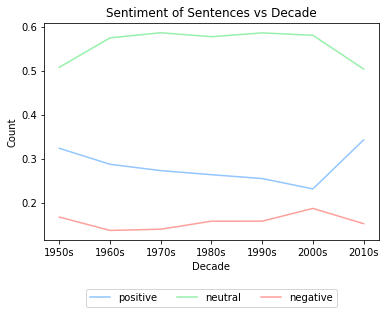

In [93]:
for sentiment in sentiments:
    plt.plot(music["Decade"], sentiment_summary[sentiment], label=sentiment)
plt.ylabel("Count")
plt.xlabel("Decade")
plt.title("Sentiment of Sentences vs Decade");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3);
#plt.savefig("img/sentvsdecade.tiff");

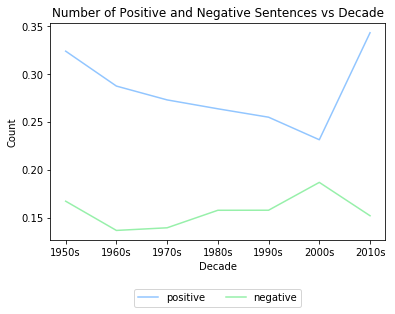

In [94]:
plt.plot(music["Decade"], sentiment_summary[sentiments[0]], label=sentiments[0])
plt.plot(music["Decade"], sentiment_summary[sentiments[2]], label=sentiments[2])
plt.ylabel("Count")
plt.xlabel("Decade")
plt.title("Number of Positive and Negative Sentences vs Decade");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3);
#plt.savefig("img/posnegvsdecade.tiff");

## Common Words

In [95]:
#Creating lyrics lists

#By decade
lyrics_by_decade_list = []

#Overall
lyrics_freq_list = []

for i in np.arange(len(music)):
    
    decade = decade_pos_tag[i]
    lyrics_by_decade_list += [[]]
    
    for j in np.arange(len(decade)):
        
        song = decade[j]
        
        #Removing stopwords
        lyrics = [lemmatize(word, tag) for (word, tag) in song]
        lyrics = [w for w in lyrics if not w in stop_words]
        
        lyrics_by_decade_list[i] += lyrics
        lyrics_freq_list += lyrics


#Converting lyrics lists to counters
#By decade
lyrics_by_decade = [Counter(lyrics) for lyrics in lyrics_by_decade_list]

#Overall
lyrics_freq = Counter(lyrics_freq_list)

In [96]:
decade_lyric_freqs = [pd.DataFrame(data={"Word":list(decade.keys()),
                                         "Count":list(decade.values())})
                      .sort_values("Count", ascending=False)
                      for decade in lyrics_by_decade]
decade_lyric_freqs[0].head()

,Word,Count
4,dream,36
306,rock,34
107,love,32
161,im,25
48,lonely,25


In [97]:
overall_lyric_freq = pd.DataFrame(data={"Word":list(lyrics_freq.keys()),
                                        "Count":list(lyrics_freq.values())})
overall_lyric_freq = overall_lyric_freq.sort_values("Count", ascending=False)
overall_lyric_freq.head()

,Word,Count
8,get,488
161,im,417
107,love,396
135,know,375
128,dont,307


In [98]:
vectorizer = TfidfVectorizer(max_df=0.80, min_df=3, max_features=5000, stop_words=stop_words)

decade_lyrics = []

for i in np.arange(len(music["Lyrics w/o Punctuation"])):
    decade_lyrics += [" ".join(music["Lyrics w/o Punctuation"][i])]

tfidf = vectorizer.fit_transform(decade_lyrics)
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())

common = []

for i in np.arange(len(music)):
    print("Most common words of", music["Decade"][i], "are:")
    common += [tfidf.iloc[i].sort_values(ascending=False)]
    print(tfidf.iloc[i].sort_values(ascending=False).head(), "\n")

Most common words of 1950s are:
rock       0.573309
dream      0.472137
clock      0.221560
tonight    0.177248
die        0.151758
Name: 0, dtype: float64 

Most common words of 1960s are:
honey       0.442949
cry         0.391839
loves       0.252833
sunshine    0.224009
pieces      0.156807
Name: 1, dtype: float64 

Most common words of 1970s are:
breaking    0.461628
fever       0.365545
girls       0.303280
gave        0.274091
dancing     0.176913
Name: 2, dtype: float64 

Most common words of 1980s are:
faith    0.459513
body     0.287066
talk     0.274585
whats    0.242222
gotta    0.212179
Name: 3, dtype: float64 

Most common words of 1990s are:
belong    0.286381
boy       0.250862
dig       0.243804
enough    0.236575
saw       0.207233
Name: 4, dtype: float64 

Most common words of 2000s are:
low     0.531548
shit    0.328309
yet     0.273591
aint    0.273467
read    0.234506
Name: 5, dtype: float64 

Most common words of 2010s are:
happy    0.415079
maybe    0.256669
alon

In [99]:
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=20, random_state=0)
lda = lda.fit(tfidf)

In [100]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [101]:
tf_feature_names = vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 50)


Topic #0:
rock dream clock tonight die many true babe con kiss old turning ago town wanted til god lips bright near whenever white shell huh em couldnt looked lot someday begin wasnt gray letters street mean part cry young ten touched pass room although lover gave sometimes six la catch work

Topic #1:
happy maybe along sorry hands everybody hot good body met party watch deep somebody hit damn fall tonight bring late rock wish lead going room uh getting crazy sound looking girls dark truth fight falling yo blow house pocket whoo storm shit kiss talk ready hate mi road shake somethin

Topic #2:
low breaking honey aint cry fever yet girls shit gave nobody loves face read sunshine light ah gimme gotta burn pieces fun sky wrote brown dancing pour taking sweet sun help knows friend shine uh beat whole weve days hide goodbye fall makes hard couldnt isnt hit open thing warm

Topic #3:
faith body talk whats gotta maybe shell watching dance lover eye cry anytime talkin good move says sure step

In [125]:
n_topics = 2
for i in range(len(music["Lyrics"])):
    print("\nTopics of the", music["Decade"][i]+":")
    decade_vec = TfidfVectorizer(max_df=0.80, min_df=3, max_features=5000, stop_words=stop_words)
    decade_tfidf = decade_vec.fit_transform(music["Lyrics w/o Punctuation"][i])
    decade_lda = LatentDirichletAllocation(n_components=n_topics, max_iter=20, random_state=0)
    decade_lda = decade_lda.fit(decade_tfidf)
    decade_tf_feature_names = decade_vec.get_feature_names()
    print_top_words(decade_lda, decade_tf_feature_names, 50)


Topics of the 1950s:

Topic #0:
oh ago see long someone town could arms dreams know many find theres ill little go really river take new eyes bright one round said part night never well two may say ever hear come like true must start always made life way youre heart love dont kiss around please

Topic #1:
love heart im lonely smile like dont kiss ever day around may well always youre ill way die away say please true life near lips night made little mine must never pass know dreams many could bright youll part start take theres two arms hear eyes see one come someone

Topics of the 1960s:

Topic #0:
let want tell time gone ive way gonna love someone friend say ill pretend live heart long like know cant youre youll mind got make come man well im go knows dreams start right understand feel since little apart see alone sweet true one blue life kissed oh sun yeah

Topic #1:
yeah dont im love cant get go cause baby summer know blue world got take lonely eyes come oh one heart dreams alone l

## Visualization
### Top 10 most Frequent Words
#### By Decade

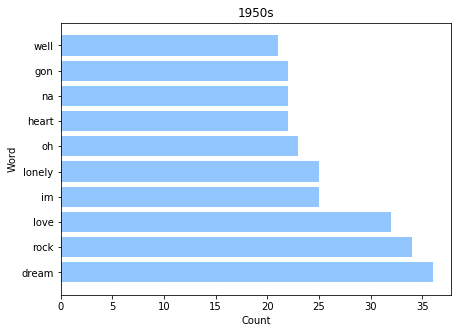

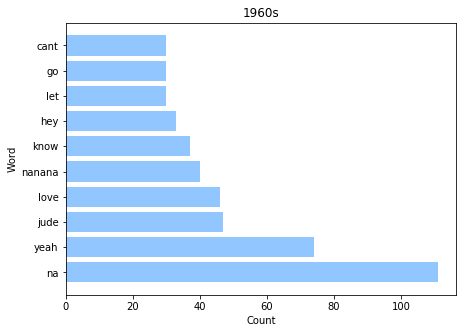

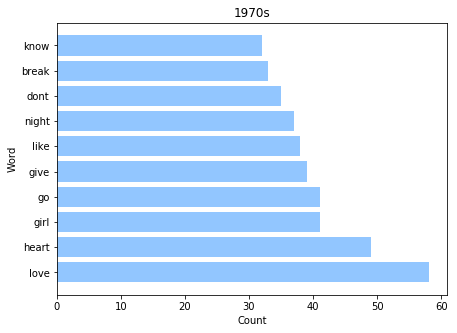

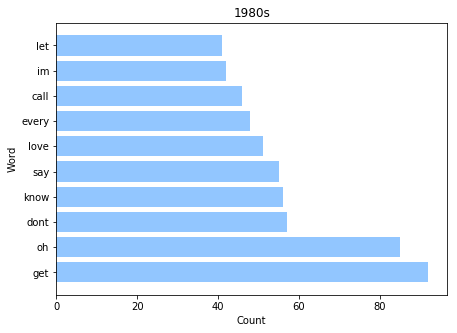

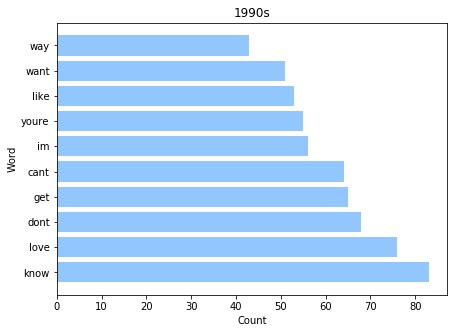

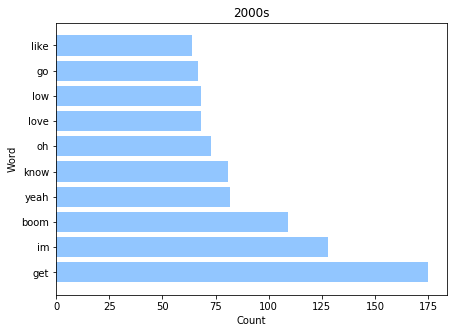

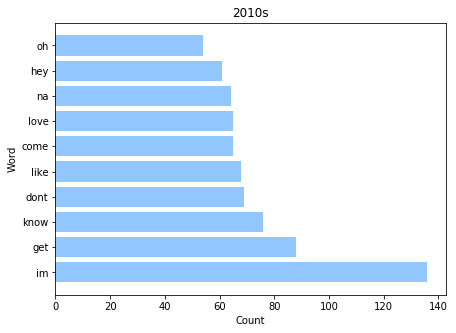

In [79]:
titles = music["Decade"]
i = 0
words_10 = []
for decade in decade_lyric_freqs:
    words_10.extend(list(decade["Word"]))
    plt.figure(figsize=(7,5))
    plt.barh(decade["Word"][:10], decade["Count"][:10])
    plt.title(titles[i])
    plt.ylabel("Word")
    plt.xlabel("Count")
    #plt.savefig("img/"+titles[i]+"wordbar.tiff")
    plt.show();
    i += 1
words_10 = Counter(words_10)

In [40]:
#max is 7
words_10_duplicates = [i for i in words_10.elements() if words_10[i] > 6]
print(Counter(words_10_duplicates))

Counter({'love': 7, 'im': 7, 'oh': 7, 'heart': 7, 'na': 7, 'gon': 7, 'well': 7, 'say': 7, 'ill': 7, 'want': 7, 'dont': 7, 'like': 7, 'baby': 7, 'could': 7, 'day': 7, 'give': 7, 'know': 7, 'see': 7, 'someone': 7, 'go': 7, 'always': 7, 'thats': 7, 'way': 7, 'take': 7, 'make': 7, 'get': 7, 'look': 7, 'youre': 7, 'please': 7, 'night': 7, 'never': 7, 'find': 7, 'let': 7, 'away': 7, 'turn': 7, 'come': 7, 'thing': 7, 'life': 7, 'break': 7, 'hold': 7, 'one': 7, 'back': 7, 'cry': 7, 'hand': 7, 'youll': 7, 'wait': 7, 'long': 7, 'think': 7, 'time': 7, 'stop': 7, 'two': 7, 'start': 7, 'mine': 7, 'touch': 7, 'live': 7, 'yeah': 7, 'nothing': 7, 'last': 7, 'line': 7, 'right': 7, 'lose': 7, 'need': 7, 'tell': 7, 'feel': 7, 'hear': 7, 'eye': 7, 'id': 7, 'every': 7, 'girl': 7, 'walk': 7, 'cant': 7, 'leave': 7, 'still': 7, 'mind': 7, 'stand': 7, 'share': 7, 'cause': 7, 'ive': 7, 'home': 7, 'ooh': 7, 'another': 7, 'call': 7, 'much': 7, 'name': 7, 'play': 7, 'dance': 7, 'star': 7, 'inside': 7, 'try': 7, 'a

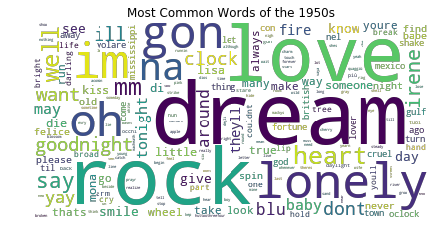

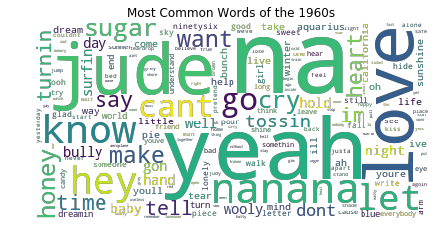

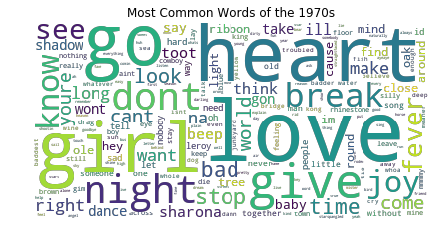

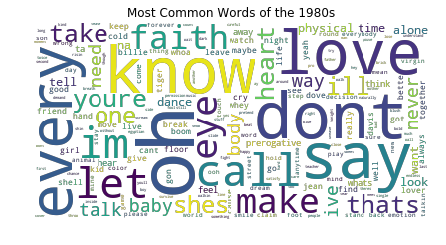

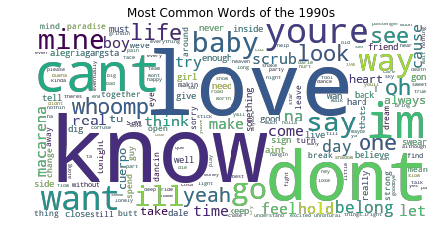

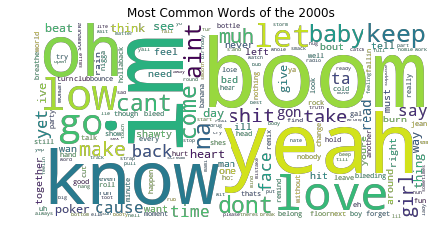

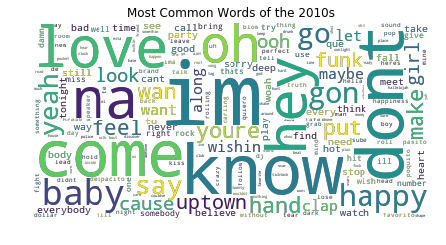

In [69]:
titles = music["Decade"]
i = 0

for decade in lyrics_by_decade_list:
    decade = " ".join(decade)
    wordcloud = WordCloud(mode="RGBA", background_color=None, collocations=False).generate(decade)
    fig = plt.figure()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title("Most Common Words of the " + titles[i])
    plt.show();
    #wordcloud.to_file("img/"+titles[i]+"words.tiff")
    i += 1

#### Overall

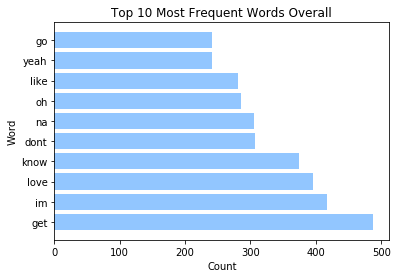

In [103]:
plt.barh(overall_lyric_freq["Word"][:10], overall_lyric_freq["Count"][:10])
plt.xlabel("Count")
plt.ylabel("Word")
plt.title("Top 10 Most Frequent Words Overall");
#plt.savefig("img/overallwordbar.tiff");

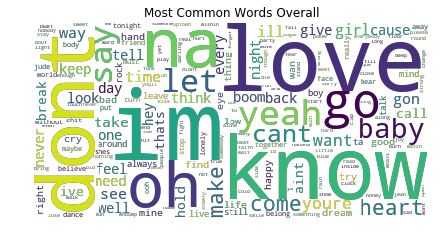

In [71]:
overall = " ".join(lyrics_freq_list)
wordcloud = WordCloud(mode="RGBA", background_color=None, collocations=False).generate(overall)
fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Most Common Words Overall")
plt.show();
#wordcloud.to_file("img/overallwords.tiff");

### TF-IDF

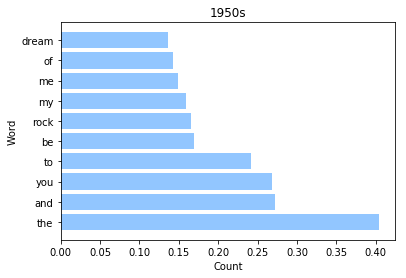

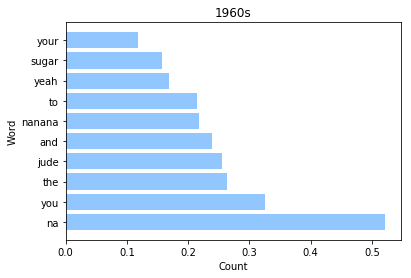

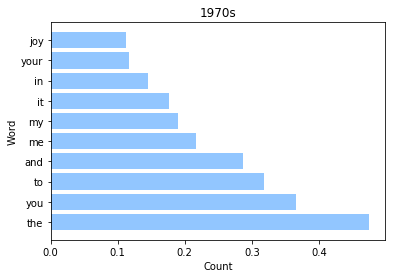

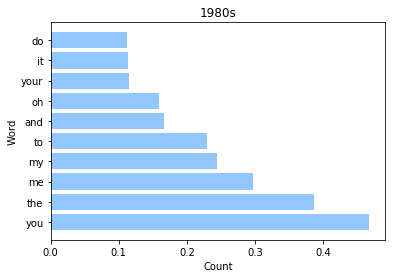

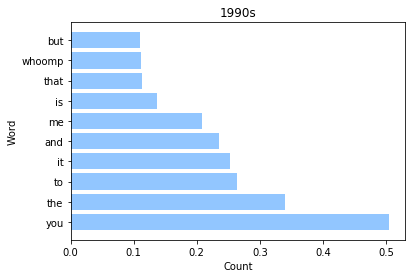

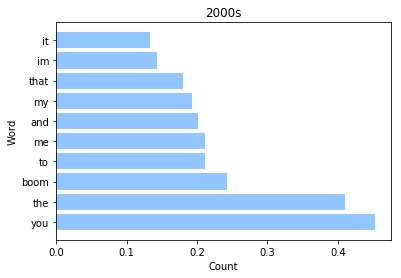

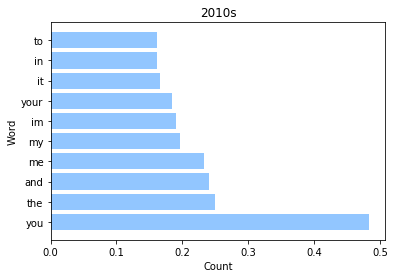

In [104]:
titles = music["Decade"]
i = 0

for decade in common:
    plt.barh(decade.index[:10], decade[:10])
    plt.title(titles[i])
    plt.xlabel("Count")
    plt.ylabel("Word")
    #plt.savefig("img/"+titles[i]+"wordbar.tiff")
    plt.show();
    i += 1

# Conclusion and Further Paths of Research
From the basic analysis of the dataset, I found out that although the number of unique artists stayed about the same throughout the period examined (1950s-2010s), the histogram of the frequencies of number of appearances combined with the bar chart of the top most popular artists shows that, of the repeat artists, there appears to be a consolidation of popularity. There is a shift from many repeat artists showing up in the top 30 spots to only a few artists making many appearances in the top 30 spots.

The rest of my analysis was focused on the lyrics and how the lyrical characteristics of the songs changed through time.

When examining the length of the lyrics, I discovered a strong trend towards shorter, more repetitive, and more numerous words. I've listened to some of the songs and empirically, I've noticed that the earlier songs had more instrumentals and were usually shorter in length upper 2, lower 3 minutes). Although the songs also become more repetitive (repeating phrases more) so that trend may be related to that and would require further analysis to tease them apart, I this correlation is related to another confouding factor. But whether this is explained because songs have become longer, or the lyrical segments of songs have become longer, or a genre shift to genres with a greater emphasis on the lyrical content has occurred, cannot be fully explored with the current dataset. However, when referencing ["Music Trends Through The Decades" by Rifftime](https://medium.com/@Rifftime_Music/music-trends-through-the-decades-b8c5cbbae08b), I've learned the popular genres of each decade were:

1950s: Rock ’N Roll, B-bop, Big Band, Country

1960s: Motown, Rock ‘N Roll, and The British Invasion

1970s: Disco, Motown, and R&B

1980s: Glam rock, Pop, Hip-Hop, Country

1990s: Grunge, Alternative, Rap, and Country

2000s: Adult Contemporary and R&B

2010s: EDM and Hip-Hop

A possible explanation of the trend displayed in the data set could be the popularity of hip-hop and rap, a very wordy and lyrically-focused genre, and the fading popularity of big band, a genre more focused on the instrumentals. However, further investigation is needed to confirm or deny the validity of this hypothesis. In the future, it may be interesting attaching the genres of the songs to the dataset and analyzing their distribution through the decades and their distinctive lyrical characteristics.

The next set of analysis performed were on the POS (parts of speech) of the words in the songs. The POS distribution for the 1950s, the 1970s, and the 2000s interests me because the distributions of the parts of speech has a lot of nouns and very few of everything else. I'm not sure why that is the case for those decades specifically. I believe a closer reading of the lyrics in those decades may prove valuable.

Analyzing the pronouns used, there is a trend of more personal pronouns in songs. In the 1980s, possessive personal pronouns overtook personal pronouns, which is an interesting relationship considering it's the only time that happened, so closer analysis of the music in that decade is a path I could embark from here.

Interestingly, first person and second person pronouns show an approximately proportionate increase over the decades, which seems to signify the growing popularity of more personal, relationship-centric songs.

After reading ["Why I Dig: Feminist Approaches to Text Analysis" by Lisa Marie Rhody](http://dhdebates.gc.cuny.edu/debates/text/97), I was inspired to look at the frequency of male and female pronouns over the decades and saw a back and forth between the pronouns. However, in the 1950s, female pronouns were at an all time high. The [second wave feminist movement](https://www.britannica.com/topic/womens-movement) was in the 1960s and 1970s, which coincided with the sharp decrease in female pronoun usages since 1950s. If we assume the pronouns reflect the love interest being sung about by the artist (since love is a frequent topic in all the decades), then the feminist movement may have lead to a change of public opinion so that such potentially more objectifying way (singing about a third party to the listener) of singing fell out of favor and the more personal "you" being more popular (since both male and female pronouns are not as common as in 1950s). In the 2010s, there's another small drop in third person pronoun usage as well, so it may be interesting to investigate the cause of that.

However, it's not a given that the third person pronoun usage is necessarily objectifying nor that there is a correlation between the feminist movement and the drop in female pronoun usage. Further investigation would be need to clarify the relationship, if any, and what it means.

Characteristics that seem to stay roughly the same through the decades are the sentiments and infantilization. The phrases in the songs are usually neutral, and tend to use more positive words than negative. The common words use tend to be casual (gonna, yay) and when referring to another person, tends to favor infantilizing words (baby, girl, boy). Those words are often also considered terms of endearment (see: the entirety of Justin Beiber's "Baby"), but it's interesting to see how these terms persist over the decades over alternatives (honey, sweetheart, dear, love). Examining the relationship between terms of endearment in songs over the decades, and the public's perception of what love is may be an interesting project to take.

The common words used tend to be standard and colloqial English, and not characterisitc of any subgroups. This supports the idea that the artists try to relate to the largest group possible since this is language many would be familiar with. This may also explain the shift from the "he" or "she" to the personal yet more specific "you". For example, the song Goodnight Irene was originally a folk song sung by Huddie Ledbetter, an African-American murderer. However, it didn't become popular until The Weavers, a folk music quartet, made it more wholesome and less bleak, which made it appeal to more people [(Source 1)](https://www.ft.com/content/ba35fd76-6928-11e5-97d0-1456a776a4f5)[(Source 2)](https://www.liveabout.com/goodnight-irene-1322496). The original references morphine and said that her mother said that Irene was "too young" which are more controversial topics to middle-class Americans. The Weaver's version don't mention those at all, and is just a saccharine love song.

# Related Works and What I Could've Done Better
In the article [Billboard Hot 100 Analytics](https://towardsdatascience.com/billboard-hot-100-analytics-using-data-to-understand-the-shift-in-popular-music-in-the-last-60-ac3919d39b49), Rosebud Anwuri analyzed Billboard's Hot 100 charts from 1950–2015 (with data from https://github.com/kevinschaich/billboard) using Spotify’s API. She noticed a trend towards less instrumentals and more speechiness over the decades, especially in the 1990s. She connected it with the rise of hip-hop and the types of bands that were popular: rock bands were replaced by pop bands. Finally, she showed that loudness has been on the rise over the decades.

Her findings relate to my own findings as well: especially with the speechiness of the recent songs. The data she used doesn't cover as long of a time period as mine (hers ends at 2015 while mine ends at 2018). However, the repo she took the data from had some interesting basic analysis done. In the future, I would be interested in using Spotify's API as well as looking at some of the features Kevin Schaich added to his dataset. However, when I first encountered these things, I knew far less than I do now so I wasn't sure how to utilize what I found. 

If I had more time and/or money, I would've definitely included more songs. From certain word clouds, because I didn't have enough datapoints, certain very repetitive and song-specific phrases from certain songs (examples include: "goodnight Irene" from "Goodnight Irene", "wooly bully" from "Wooly Bully", "uptown funk you up" from "Uptown Funk") end up showing up very prominently in the data.

Additionally, in my latest iteration of the data inputed, I took the top 2 songs from each year as the corpus for each decade. As my latest data is 2018, the 2010s data contains less songs than the others, so is more subject to the individual characteristics of the songs in that decade.

Although it's not an issue now, the earlier Billboard top singles lists only lists 30 while the later ones list 50 or 100. Therefore, if I wanted a balanced dataset, the data would end up capped at 30 songs per year so if I wish to include more data, I would need to be mindful of that and perhaps find another source.

Another thing I think I could've done better was include more characteristics. As it was my first time doing web-scraping, I only managed to collect the ranking data from Wikipedia and didn't know how to efficently and accurately append data from other sources. My compromise was to manually include lyrics to the dataset, and although I was able to get a lot of interesting information from just the lyrics, if I had more information such as the gender of the artists, the genre, the length of the songs, or the sheet music, I could definitely do a more complex and insightful analysis. Perhaps after more experience, I would return to this project and redo it with more finesse.